# Testing SAM Model

In [1]:
!pip install customtkinter
!pip install segment-anything
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install supervision

  Cloning https://github.com/facebookresearch/segment-anything.git to c:\users\mracz\appdata\local\temp\pip-req-build-tf6o4c67
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git 'C:\Users\mracz\AppData\Local\Temp\pip-req-build-tf6o4c67'


In [2]:
import os
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg, NavigationToolbar2Tk
import platform
import numpy as np
import torchvision
import cv2
import PIL
import tkinter as tk
from tkinter import *
from PIL import ImageTk, Image
import customtkinter as ctk
from customtkinter import *
import os
import sys
import supervision as sv
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry

HOME = os.getcwd()
print("HOME:", HOME)


CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))


HOME: c:\Users\mracz\Documents\SAM_project
c:\Users\mracz\Documents\SAM_project\weights\sam_vit_h_4b8939.pth ; exist: True


IMG_9928.jpeg


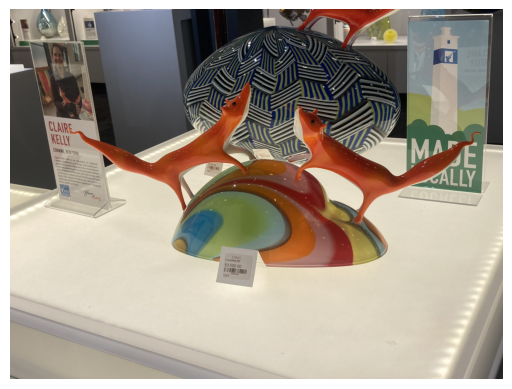

In [3]:
#path = f'{HOME}/IMG_9928.jpeg'
path='IMG_9928.jpeg'
print(path)
assert path is not None, "No file selected"

image_bgr = cv2.imread(path)

assert image_bgr is not None, "No image selected"
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

plt.axis('off')
plt.imshow(image_rgb)

#image_bgr.shape

#plt.imshow(image)

#if file doesnt exist error, say "file not found" else imshow

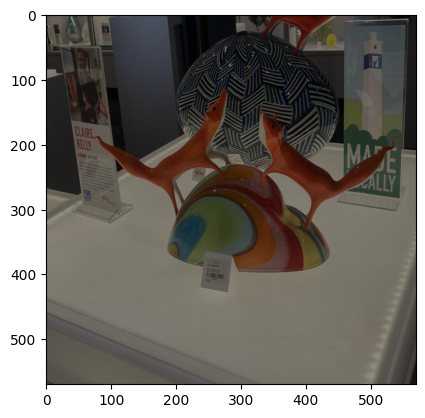

Exception in Tkinter callback
Traceback (most recent call last):
  File "c:\Users\mracz\AppData\Local\miniconda3\envs\guienv2\Lib\tkinter\__init__.py", line 1967, in __call__
    return self.func(*args)
           ^^^^^^^^^^^^^^^^
  File "C:\Users\mracz\AppData\Local\Temp\ipykernel_10624\3693072157.py", line 185, in hover_mask
    for mask in self.masks: #gives you the (x1, y1, x2, y2) tuple of the canvas' coordinates
                ^^^^^^^^^^
  File "c:\Users\mracz\AppData\Local\miniconda3\envs\guienv2\Lib\tkinter\__init__.py", line 2429, in __getattr__
    return getattr(self.tk, attr)
           ^^^^^^^^^^^^^^^^^^^^^^
AttributeError: '_tkinter.tkapp' object has no attribute 'masks'
Exception in Tkinter callback
Traceback (most recent call last):
  File "c:\Users\mracz\AppData\Local\miniconda3\envs\guienv2\Lib\tkinter\__init__.py", line 1967, in __call__
    return self.func(*args)
           ^^^^^^^^^^^^^^^^
  File "C:\Users\mracz\AppData\Local\Temp\ipykernel_10624\3693072157.py", 

In [62]:
ctk.set_appearance_mode("Dark")
ctk.set_default_color_theme("blue")

class Wales(ctk.CTk):


    def __init__(self):
    #sets instance SAM variables and creates window
        super().__init__()

        self.title("WALES")
        self.geometry("1700x1000")

        self.points_per_side = tk.IntVar()
        self.points_per_side.set(25)
        self.pred_iou_thresh = tk.DoubleVar()
        self.pred_iou_thresh.set(0.6)
        self.stability_iou_thresh = tk.DoubleVar()
        self.stability_iou_thresh.set(0.6)
        self.crop_n_layers = tk.IntVar()
        self.crop_n_layers.set(0)
        self.zoom = tk.IntVar()
        self.zoom.set(0)

        self.mode = tk.BooleanVar()
        self.mode.set(1)

        #creates buttons and grids them
        
        self.add_mask_button = ctk.CTkButton(self, text="Add Mask",height=90,width=350,font=("Times New Roman", 55),text_color="black",fg_color="#04ff00",hover_color="#04ad02",corner_radius = 15,
                                                command=self.add_mask
                                                )
        
        self.run_SAM_button = ctk.CTkButton(self,text="RUN SAM",height=70,width=300,font=("Times New Roman", 55),text_color="black",fg_color="#00ff77",hover_color="#02b857",corner_radius = 15,
                                            command=self.run_SAM
         )
        
        self.delete_mask_button = ctk.CTkButton(self, text="Delete Mask",height=90,width=350,font=("Times New Roman", 55),text_color="black",fg_color="red",hover_color="#ba0202",corner_radius = 15,
                                                command=self.delete_mask
                                                )
        
        self.settings_button = ctk.CTkButton(self, text="Settings",height=50,width=175,font=("Times New Roman", 35),text_color="white",fg_color="#a6a6a6",hover_color="#6b6b6b",corner_radius = 15,
                                                command=self.access_settings,
                                                )
        
        self.plus_button = ctk.CTkButton(self, text="+", height=100, width=100, text_color='white', corner_radius=100, fg_color='green', font=('Arial', 70),
                                         command=self.plus)
        
        self.minus_button = ctk.CTkButton(self, text="-", height=100, width=100, text_color='white', corner_radius=100, fg_color='red', font=('Arial', 89),
                                         command=self.minus)

        

        self.add_mask_button.grid(row=0, column=0, pady=30, padx=100)
        self.delete_mask_button.grid(row=0, column=1, padx=100)
        self.settings_button.grid(row=0, column=2, padx=100)
        self.run_SAM_button.grid(row=1, column=2, padx=100)

        #creates image, puts it on canvas, and grids canvas
        #also keeps in mind a certain width and height of 
        #how the final image will be displayed (that resized image = self.final_img)

        width=570
        height=570

        self.image_rgb = Image.open(path).convert('RGB') #converts to PIL image, in RGB format
        self.image_rgb = self.image_rgb.resize((width,height), Image.LANCZOS) #resizes image, also will correlate masks
        #self.image_rgba = self.image_rgb.convert('RGBA') #converts to rgba
        self.image_array = np.array(self.image_rgb, dtype=np.uint8) #converts rgba image to array 
        self.image_array = np.uint8(self.image_array[:,:,:3]*0.55) #dims array by making all r,g,b values 0.3 their normal self, then converting any float vals to ints (0 to 255 scale of brightness)
        a_channel = ((np.ones((height, width),dtype=np.uint8))*255).astype(self.image_array.dtype) #makes displayed image opaque (0 to 255 scale of opacity)
        self.image_array = np.dstack((self.image_array, a_channel)) #merges both into rgba array
        self.image_array = np.flipud(np.fliplr(self.image_array)) #makes it not backwards and upside-down
        plt.imshow(self.image_array)
        plt.show()
        #self.image_array = np.uint8(self.image_array)
        self.final_img = Image.fromarray(np.uint8(self.image_array))#.convert('RGB') #converts image array to image
        self.final_img = ImageTk.PhotoImage(self.final_img) #makes image tkinter-friendly
        

        #creates and grids canvas that displays dimmed image

        self.image_display_canvas = ctk.CTkCanvas(self, width=width, height=height)
        self.image_display_canvas.grid(row=2, column=1)
        self.plus_button.place(x=1200,y=370)
        self.minus_button.place(x=1208,y=530)

        #displays final_img; if final_img updates, so does the display
        self.image_display_canvas.create_image(0, 0, image=self.final_img, anchor="nw")

        self.image_display_canvas.bind('<Motion>', self.hover_mask)
        self.image_display_canvas.bind('<Button-1>', self.click_mask)


    #creates settings tab, with entryboxes and buttons

    def access_settings(self):
        settings_window = ctk.CTkToplevel(self)
        settings_window.title("Settings")
        settings_window.geometry("850x900")

        settings_tabs = ctk.CTkTabview(settings_window,width=850,height=900,corner_radius=15,fg_color="#b0b0b0",segmented_button_unselected_hover_color="#5B5B5B",segmented_button_unselected_color="#868686",segmented_button_selected_color="#0059ff",segmented_button_selected_hover_color="#0242ba",)
        settings_tabs.grid(pady=0)

        settings_tabs._segmented_button.configure(font=("Times New Roman", 27))

        save_controls_tab = settings_tabs.add("Controls")
        SAM_settings_tab = settings_tabs.add("SAM Settings")

        #creates an entrybox for points_per_side, alongside an explanatory label
                                        
        points_per_side_entrybox = ctk.CTkEntry(SAM_settings_tab,
                                    placeholder_text=self.points_per_side.get(),
                                    height=50,width=100,font=("Times New Roman", 16),corner_radius=15,
                                    textvariable=self.points_per_side
                                    )
            
        points_per_side_entrybox.grid(padx=10)
        pps_label = ctk.CTkLabel(SAM_settings_tab, text="\nNumber of points on each side, considered by SAM Model. \nMore points increases accuracy and analyzing time.\n", font=("Times New Roman", 18), text_color="black")
        pps_label.grid(row=0, column=1, padx=20)

        #creates an entrybox for pred_iou_thresh, alongside an explanatory label

        pred_iou_thresh_entrybox = ctk.CTkEntry(SAM_settings_tab,
                                     placeholder_text=self.pred_iou_thresh.get(),
                                     height=50,width=100,font=("Times New Roman", 16),corner_radius=15,
                                     textvariable=self.pred_iou_thresh
                                     )
        
        pred_iou_thresh_entrybox.grid()
        pit_label = ctk.CTkLabel(SAM_settings_tab, text="\n0-1 scale, Filters masks based on accuracy.\n Higher filters are more selective, and take less time to analyze.\n", font=("Times New Roman", 18), text_color="black")
        pit_label.grid(row=1, column=1, padx=20)

        #creates an entrybox for stability_iou_thresh, alongside an explanatory label
        stability_score_thresh_entrybox = ctk.CTkEntry(SAM_settings_tab,
                                     placeholder_text=self.stability_iou_thresh.get(),
                                     height=50,width=100,font=("Times New Roman", 16),corner_radius=15,
                                     textvariable=self.stability_iou_thresh
                                     )
        
        stability_score_thresh_entrybox.grid()
        sst_label = ctk.CTkLabel(SAM_settings_tab, text="\n0-1 scale, Filters masks based on how often they appear in all masks \n generated on an image. Higher filters are more selective, \nand take less time to analyze.\n", font=("Times New Roman", 18), text_color="black")
        sst_label.grid(row=2, column=1, padx=20)

        #creates an entrybox for crop_n_layers, alongside an explanatory label
        crop_n_layers_entrybox = ctk.CTkEntry(SAM_settings_tab,
                                     placeholder_text=self.crop_n_layers.get(),
                                     height=50,width=100,font=("Times New Roman", 16),corner_radius=15,
                                     textvariable=self.crop_n_layers
                                     )
        
        crop_n_layers_entrybox.grid()
        cnl_label = ctk.CTkLabel(SAM_settings_tab, text="\nNumber of additional layers of image that are analyzed, to compare any masks \nbetween layers. More layers catch more masks, and take longer to analyze.\n", font=("Times New Roman", 18), text_color="black")
        cnl_label.grid(row=3, column=1, padx=20)

        save_SAM_settings_button = ctk.CTkButton(SAM_settings_tab, text="SAVE", width=600, height=80, fg_color='#00ffff', font=('Times New Roman', 50), text_color='black',
                                                      command=self.create_SAM)
        
        save_SAM_settings_button.grid(row=4, column=1, pady=50)

    #sets mode to 0, which causes the logical_not version of a mask to be added

    def delete_mask(self):
        self.mode.set(0)

    #sets mode to 1, which causes a mask to be added

    def add_mask(self): 
        self.mode.set(1)

    def plus(self):
        self.zoom+=1
    
    def minus(self):
        self.zoom-=1
        if(self.zoom<=0):
            self.zoom.set(0)
            self.minus_button._state = 'off'
        else:
            self.minus_button._state = 'on'

    #if hover over mask, alpha = 1, which makes it full brightness, in contrast to the dimmed background
    #the chosen mask therefore pops
    def hover_mask(self, event): #change from self.masks to self.shown_masks
        for mask in self.masks: #gives you the (x1, y1, x2, y2) tuple of the canvas' coordinates
            if((mask.get('point_coords')[0] <= self.image_display_canvas.canvasx(event.x) <= mask.get('point_coords')[2]) and (mask.get('point_coords')[1] <= self.image_display_canvas.canvasy(event.y) <= mask.get('point_coords')[3])):
                self.selected_mask = mask
                self.image_array = np.uint8(self.image_array[:,:,:3]*1.5)  #if cursor moves between area of image with mask, brightens that mask 1.5x to make it pop


#if click mask, add regular to image if mode=1, add logical_not if mode=0

    def click_mask(self, event):
        if(self.mode): #ADD
            self.image_array[self.selected_mask] = np.max(self.selected_mask, self.image_array)
            self.final_img = Image.fromarray(self.image_array) #add part of image to image_rgba where mask is, then update final_image 
        else: #DELETE
            self.image_array[self.selected_mask] = np.min(self.selected_mask, np.logical_not(self.image_array))
            self.final_img = Image.fromarray(self.image_array) #add deleted part of image to image_rgba where mask is, then update final_image 

#show masks 
    '''def show_anns(anns): #anns = self.masks
        if len(anns) == 0:
            return
        sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
        ax = plt.gca()
        ax.set_autoscale_on(False)

        img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
        img[:,:,3] = 0
        for ann in sorted_anns:
            m = ann['segmentation']
            color_mask = np.concatenate([np.random.random(3), [0.35]])
            img[m] = color_mask'''

       #self.final_img is already displayed on canvas, so doesn't need to be shown and annotated again
       #when its own RGB values are played with, as to create random colors for each mask (ann)

    def get_relevant_masks(self):
        self.masks = sorted(self.masks, key=(lambda x: x['area']), reverse=True)
        if(((self.zoom+1)*10)>len(self.masks)):
            self.shown_masks = self.masks[(self.zoom*10), len(self.masks)]
            self.plus_button._state='off'
        else:
            self.shown_masks = self.masks[(self.zoom*10), ((self.zoom+1)*10)]
            self.plus_button._state='on'


    #creates new SAM model with updated parameters and runs it on image

    def create_SAM(self):
        sys.path.append("..")
        sam_checkpoint = "sam_vit_h_4b8939.pth"
        model_type = "vit_h"
        device = "cuda"

        sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
        sam.to(device=device)

        self.mask_generator_ = SamAutomaticMaskGenerator(model=sam,
                                                    points_per_side=self.points_per_side.get(),
                                                    pred_iou_thresh=self.pred_iou_thresh.get(),
                                                    stability_score_thresh=self.stability_iou_thresh.get(),
                                                    crop_n_layers=self.crop_n_layers.get()
                                                    )
        
    def run_SAM(self):
        self.masks = self.mask_generator_.generate(self.final_img)
        #self.show_anns(self.masks)
        
#creates an instance of the program and runs it
WALES = Wales()
WALES.mainloop()   

(-0.5, 4031.5, 3023.5, -0.5)

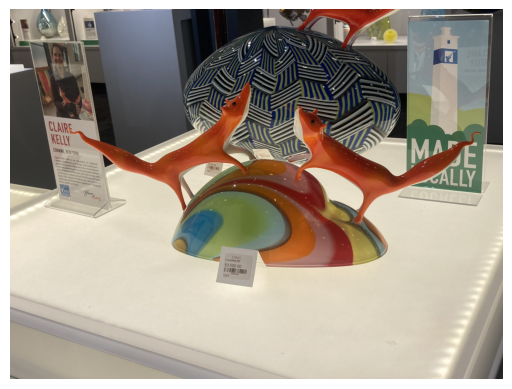

In [5]:
plt.figure() #figsize=(20, 20)
plt.imshow(image_rgb)
plt.plot()
plt.axis('off')

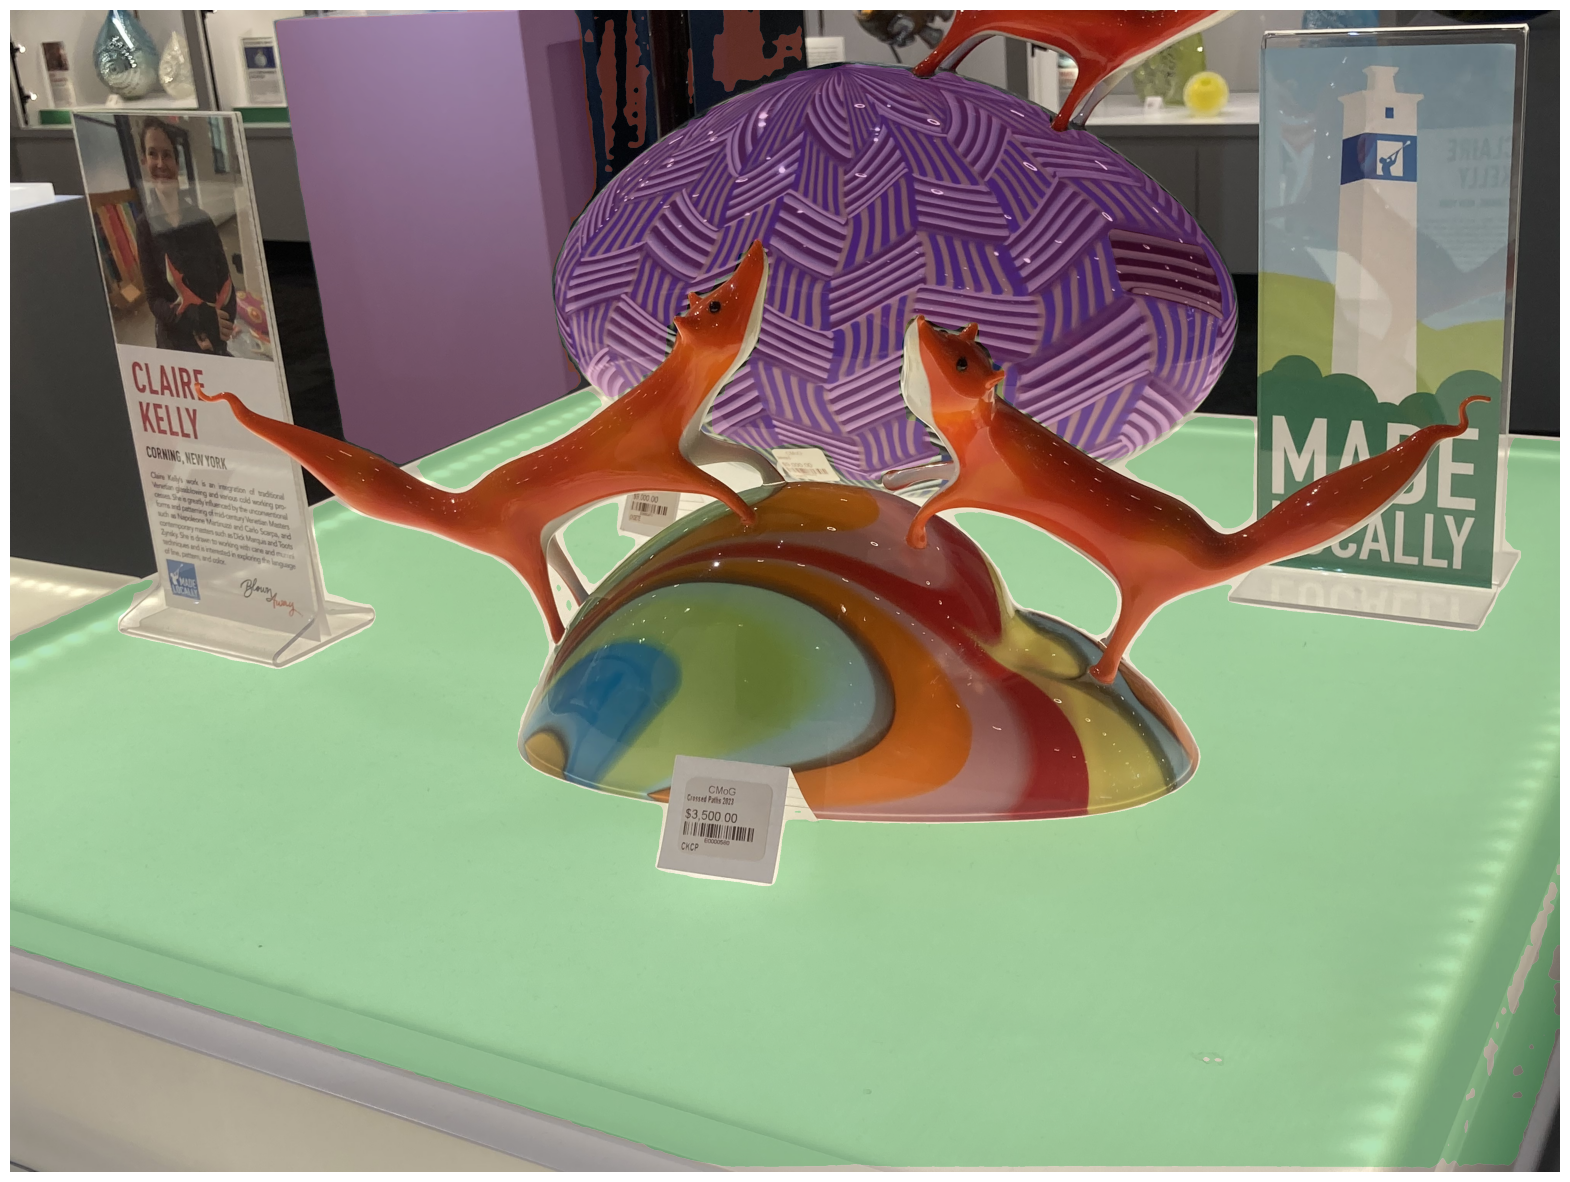

In [6]:

sys.path.append("..")
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator_ = SamAutomaticMaskGenerator(model=sam,
                                            points_per_side=2,
                                            pred_iou_thresh=0.8,
                                            stability_score_thresh=0.8,
                                            crop_n_layers=0
                                            )

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [.35]])
        img[m] = color_mask
    ax.imshow(img)

plt.figure(figsize=(20,20))
plt.axis('off')
plt.imshow(image_rgb)
masks = mask_generator_.generate(image_rgb)
show_anns(masks)
plt.show() 